In [ ]:
import tensorflow as tf
import os
tf.__version__

'2.8.0'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
file_path='/content/drive/MyDrive/dt_2'
train_path='/content/drive/MyDrive/dt_2/train'
train_normal_path='/content/drive/MyDrive/dt_2/train/Normal'
train_osteoporosis_path='/content/drive/MyDrive/dt_2/train/Osteoporosis'
validation_path='/content/drive/MyDrive/dt_2/val'
validation_normal_path='/content/drive/MyDrive/dt_2/val/Normal'
validation_osteoporosis_path='/content/drive/MyDrive/dt_2/val/Osteoporosis'
test_path='/content/drive/MyDrive/dt_2/test'
test_normal_path='/content/drive/MyDrive/dt_2/test/Normal'
test_osteoporosis_path='/content/drive/MyDrive/dt_2/test/Osteoporosis'

In [ ]:
train_images = []
train_labels = [] 

In [ ]:
import numpy as np 
import matplotlib.pyplot as plt
import glob
import cv2
for directory_path in os.listdir(train_path):
    label = directory_path.split("\\")[-1]
    for img_path in  glob.glob(os.path.join(train_path,directory_path, "*")):
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)  
        img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)     
        img = cv2.resize(img, (224, 224))
        train_images.append(img)
        train_labels.append(label)

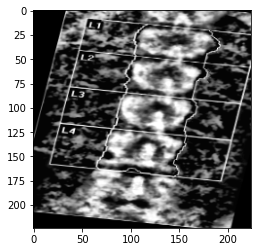

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
plt.imshow(train_images[0],cmap="gray")

In [ ]:
train_images[0].shape

(224, 224)

In [ ]:
train_images = np.array(train_images)
train_labels = np.array(train_labels)

In [ ]:
test_images = []
test_labels = [] 

In [ ]:
import numpy as np 
import matplotlib.pyplot as plt
import glob
import cv2
for directory_path in os.listdir(test_path):
    label = directory_path.split("\\")[-1]
    for img_path in  glob.glob(os.path.join(test_path,directory_path, "*")):
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)    
        img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)     
        img = cv2.resize(img, (224, 224))
        test_images.append(img)
        test_labels.append(label)

In [ ]:
test_images = np.array(test_images)
test_labels = np.array(test_labels)

In [ ]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(test_labels)
test_labels_encoded = le.transform(test_labels)
le.fit(train_labels)
train_labels_encoded = le.transform(train_labels)

In [ ]:
x_train, y_train, x_test, y_test = train_images, train_labels_encoded, test_images, test_labels_encoded

In [ ]:
from tensorflow.keras.utils import to_categorical
y_train_one_hot = to_categorical(y_train)
y_test_one_hot = to_categorical(y_test)

In [ ]:

IMAGE_SIZE = [224, 224,3]
ef_model = tf.keras.applications.inception_v3.InceptionV3(input_shape=IMAGE_SIZE,include_top=False, weights='imagenet')

87924736/87910968 [==============================] - 1s 0us/step


In [ ]:
ef_config = ef_model.get_config()

In [ ]:
h, w, c = 224, 224, 1
ef_config["layers"][0]["config"]["batch_input_shape"] = (None, h, w, c)

In [ ]:
from tensorflow.keras.models import Model
ef_updated = Model.from_config(ef_config)

In [ ]:
def avg_wts(weights):  
  average_weights = np.mean(weights, axis=-2).reshape(weights[:,:,-1:,:].shape)  
  return(average_weights)

In [ ]:
ef_updated_config = ef_updated.get_config()
ef_updated_layer_names = [ef_updated_config['layers'][x]['name'] for x in range(len(ef_updated_config['layers']))]
first_conv_name = ef_updated_layer_names[1]

In [ ]:
for layer in ef_model.layers:
    if layer.name in ef_updated_layer_names:
     
      if layer.get_weights() != []:
        target_layer = ef_updated.get_layer(layer.name)
    
        if layer.name in first_conv_name: 
          weights = layer.get_weights()[0]
  
          weights_single_channel = avg_wts(weights)
                                                    
          target_layer.set_weights([weights_single_channel])  
          target_layer.trainable = False  
    
        else:  
          target_layer.trainable = False  

In [ ]:
new_model_conv1_block1_wts_updated = ef_updated.layers[4].get_weights()[0]
print(new_model_conv1_block1_wts_updated[:,:,0,0])

[[ 0.03894773 -0.01197575 -0.08386323]
 [-0.0096311  -0.07041588  0.03615351]
 [ 0.05495131 -0.10007744  0.0941989 ]]


In [ ]:
from tensorflow.keras import Sequential
model_1 = Sequential()
model_1.add(ef_updated)

In [ ]:
model_1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802208  
                                                                 
Total params: 21,802,208
Trainable params: 0
Non-trainable params: 21,802,208
_________________________________________________________________


In [ ]:
x_train=x_train/255
x_test=x_test/255

In [ ]:
feature_extractor=model_1.predict(x_train)

features = feature_extractor.reshape(feature_extractor.shape[0], -1)

In [ ]:
X_for_RF = features

In [ ]:
from sklearn.ensemble import RandomForestClassifier
RF_model = RandomForestClassifier(n_estimators = 100, random_state = 42)

In [ ]:
RF_model.fit(X_for_RF, y_train)

RandomForestClassifier(random_state=42)

In [ ]:
X_test_feature = model_1.predict(x_test)
X_test_features = X_test_feature.reshape(X_test_feature.shape[0], -1)


In [ ]:
prediction_RF = RF_model.predict(X_test_features)
y_pred=prediction_RF

In [ ]:
prediction_RF = le.inverse_transform(prediction_RF)

In [ ]:

from sklearn import metrics
print ("Accuracy = ", metrics.accuracy_score(test_labels, prediction_RF))

Accuracy =  0.8984771573604061


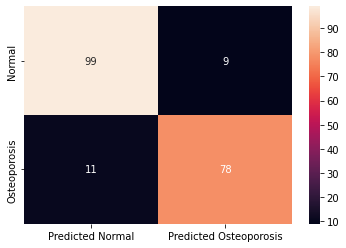

In [ ]:
from sklearn.metrics import confusion_matrix,classification_report
import seaborn as sns
import pandas as pd

cm = pd.DataFrame(data=confusion_matrix(test_labels, prediction_RF),index=[ "Normal", "Osteoporosis"],
                  columns=["Predicted Normal", "Predicted Osteoporosis"])
#print(cm)
sns.heatmap(cm, annot=True,fmt="d")

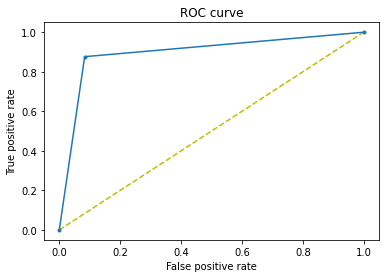

In [ ]:
from sklearn.metrics import roc_curve
y_preds = y_pred.ravel()

fpr, tpr, thresholds = roc_curve(y_test, y_preds)
plt.figure(1)
plt.plot([0, 1], [0, 1], 'y--')
plt.plot(fpr, tpr, marker='.')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.show()

In [ ]:
from sklearn.metrics import auc
auc_value = auc(fpr, tpr)
print("Area under curve, AUC = ", auc_value)

Area under curve, AUC =  0.8965355805243446


In [ ]:
print(classification_report(y_true=y_test,y_pred=y_pred,target_names =['NORMAL','Osteoporosis']))

              precision    recall  f1-score   support

      NORMAL       0.90      0.92      0.91       108
Osteoporosis       0.90      0.88      0.89        89

    accuracy                           0.90       197
   macro avg       0.90      0.90      0.90       197
weighted avg       0.90      0.90      0.90       197

